<div class="row">
  <div class="column">
<img align="left" width="200" height="42" src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" />  </div>
  <div class="column">
<img align="right" width="120" height="42" src="https://upload.wikimedia.org/wikipedia/commons/b/bd/CC-BY-NC-SA.svg"/>  </div>
</div>

Jean-Christophe Loiseau  
Maître de Conférences  
&#128231; : jean-christophe.loiseau@ensam.eu  
&#128197; : 14 Janvier 2022

In [1]:
# --> Import des librairies usuelles.
import numpy as np
import matplotlib.pyplot as plt

# --> Raccourcis.
npl, npr = np.linalg, np.random

# Introduction aux décompositions modales

Les décompositions modales font parties des outils les plus utilisés pour comprendre la structure et la dynamique de systèmes complexes tels que des écoulements turbulents.
Elles s'intègrent dans le cadre plus large des méthodes de [réduction de la dimension](https://fr.wikipedia.org/wiki/R%C3%A9duction_de_la_dimensionnalit%C3%A9).
Ces méthodes forment un corpus d'approches mathématiques consistant à prendre des données dans un espace de grande dimension (par ex: les champs de vitesse issus d'une simulation numérique hautement résolue en espace peuvent être interprétés comme des vecteurs dans $\mathbb{R}^n$ où $n$ correspond au nombre de points de maillage multiplié par le nombre de variables d'état) et à les projeter (linéairement ou non) dans un espace de plus faible dimension (par exemple $\mathbb{R}^3$). C'est une étape essentielle dans le domaine de l'[apprentissage automatique](https://fr.wikipedia.org/wiki/Apprentissage_automatique) (le nom français du *Machine Learning*) afin de lutter contre le [fléau de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).
Malheureusement, cette étape s'accompagne souvent d'une perte d'information.
Il est alors nécessaire de s'assurer que les données obtenues en sortie restent malgré tout représentatives de celles initiales.

D'un point de vue mathématique, l'étude théorique des méthodes de réduction de la dimension repose souvent sur les propriétés de régularité des données caractérisées à l'aide (entre autre) de l'[analyse harmonique](https://fr.wikipedia.org/wiki/Analyse_harmonique_(math%C3%A9matiques)#:~:text=L'analyse%20harmonique%20est%20la,et%20de%20transform%C3%A9e%20de%20Fourier.).
Par ailleurs, un résultat majeur dans ce domaine est le [lemme de Johnson-Lindenstrauss](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma).
Ce résultat théorique montre que, sous certaines conditions, il est possible de projeter des points d'un espace de (très) grande dimension dans un espace Euclidien de (beaucoup) plus faible dimension tout en préservant approximativement la distance entre chacun des points.

Il existe de très nombreuses méthodes pour réduire la dimension d'un ensemble de données.
La méthode de projection utilisée peut être linéaire ou non-linéaire.
Une liste non-exhaustive des méthodes les plus classiquement utilisées est donnée ci-dessous :
- L'[analyse en composantes principales](https://en.wikipedia.org/wiki/Principal_component_analysis) (Principal Component Analysis, PCA), aussi connue sous le nom de [Proper Orthogonal Decomposition](https://en.wikipedia.org/wiki/Proper_orthogonal_decomposition) en ingénierie mécanique ou la transformation de [Kosambi-Karhunen-Loève](https://en.wikipedia.org/wiki/Kosambi%E2%80%93Karhunen%E2%80%93Lo%C3%A8ve_theorem) en traitement du signal.
- L'[analyse des corrélations canoniques](https://fr.wikipedia.org/wiki/Analyse_canonique_des_corr%C3%A9lations) est une méthode semblable à la PCA mais appliquée à deux jeux de données variant conjointement.
- La [factorisation par matrices non-négatives](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NNMF) est utilisée en traitement des images.
- La [décomposition en modes dynamiques](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition) (DMD) pour l'identification de systèmes dynamiques.
- la [Kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis), et sa cousine la Kernel CCA, étendant l'analyse en composantes principales à l'aide de [méthodes à noyau](https://en.wikipedia.org/wiki/Kernel_method) pour des projections non-linéaires. 
- Les [auto-encodeurs](https://en.wikipedia.org/wiki/Autoencoder), un ensemble de méthodes basés sur des réseaux de neuronnes plus ou moins complexes.
- [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (*t-distributed stochastic neighbor embedding*) est une méthode non-linéaire de réduction de la dimension utilisée pour visualiser des données en 2D mais déconseillée pour construire des modèles à partir de cette projection.
- [UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection) (*Uniform Manifold Approximation and Projection*) est une méthode similaire à t-SNE mais reposant sur des *a prioris* différents concernant la distribution des données d'origine.

Dans la suite de ce tutoriel, nous nous limiterons aux méthodes linéaires, notamment l'analyse en composantes principales et la décomposition en mode dynamique.
Bien que limitées de par la méthode de projection linéaire sur laquelle elles reposent, ces deux approches permettent d'illustrer l'intérêt de ce genre de méthodes.
De plus, puisqu'elles peuvent être reformulées dans le cadre de l'algèbre linéaire numérique, elles bénéficient d'implémentations extrêmement efficaces et facilement implémentables peu importe le langage de programmation que vous utilisez.
Enfin, d'un point de vue pratique, elles permettent d'obtenir des résultats pertinents (d'un point de vue statistique) sans forcément nécessiter d'énormes volumes de données, contrairement aux méthodes basées sur des réseaux des neurones par exemple.

<div class="alert alert-block alert-info">
<b>Information pratique :</b> Même si j'essaye d'être le plus pédagogique possible, certains pré-requis sont nécessaires pour suivre ce tutoriel. Ainsi, certaines bases en algèbre linéaire et statistiques (décomposition en valeurs propres, matrice de corrélation, décomposition en valeurs singulières) peuvent vous être utiles.
    De même, je supposerai que vous êtes relativement à l'aide avec Python, et notamment les bibliothèques dédiées au calcul scientifique que sont NumPy et SciPy.
</div>

---

## Cas d'étude : l'allée tourbillonaire de Bénard-von Kàrmàn

Tout au long de ce notebook, nous utiliserons l'exemple de l'[allée de tourbillons de Bénard-von Kàrmàn](https://fr.wikipedia.org/wiki/All%C3%A9e_de_tourbillons_de_Karman) comme cas d'illustration.
Il s'agit d'une série de tourbillons contrarotatifs, transportés par l'écoulement et périodique en temps, résultant de la séparation instable de l'écoulement autour d'un corps peu profilé.
Ce phénomène est d'une grande importance dans le cas des cheminées industrielles où la fréquence de lâcher de ces tourbillons peut être proche de la fréquence propre de la structure, conduisant alors au phénomène destructeur de résonnance.

On peut modéliser ce phénomène à l'aide des équations de Navier-Stokes incompressibles

$$
\begin{aligned}
\dfrac{\partial \mathbf{u}}{\partial t} + \left( \mathbf{u} \cdot \nabla \right) \mathbf{u} & = -\nabla p - \dfrac{1}{Re} \nabla^2 \mathbf{u} \\
\nabla \cdot \mathbf{u} & = 0
\end{aligned}
$$

où $\mathbf{u}(\mathbf{x}, t)$ est le champ de vitesse, $p(\mathbf{x}, t)$ le champ de pression et $Re$ le nombre de Reynolds.
Pour des raisons évidentes de simplicité, nous nous limiterons au cas bi-dimensionel.
Afin de résoudre numériquement ces équations, il est nécessaire de les discrétiser.
Cela conduit à représenter en mémoire le champ de vitesse $\mathbf{u}(\mathbf{x}, t)$ à l'aide d'un vecteur de dimension $2n$, où $n$ est le nombre de points de maillage dans notre domaine de simulation, le facteur 2 étant lié au fait que nous avons deux composantes de vitesse.

Pour la suite de ce tutoriel, une base de données vous est fournie.
Elle consiste en 512 instantanés du champ de vitesse obtenus une fois que l'écoulement a atteint un régime stationnaire pour un nombre de Reynolds $Re = 100$ basé sur le diamètre du cylindre, la vitesse amont de l'écoulement et la viscosité dynamique du fluide.
Cette base de données a été obtenue à l'aide du code [Nek5000](https://nek5000.mcs.anl.gov/) reposant sur la méthode des [éléments spectraux](https://en.wikipedia.org/wiki/Spectral_element_method) pour la discrétisation spatiale des équations.
Afin d'en faciliter la manipulation, chacun des champs de vitesse ainsi obtenu a ensuite été interpolé sur une grille uniforme de taille 512 $\times$ 128.
Ainsi, chaque champ de vitesse est représenté en mémoire à l'aide d'un vecteur de dimension 131 072 (2 $\times$ 512 $\times$ 128).
Cette base de données contient également la pression mesurée en 64 points uniformément répartis autour du cylindre.

**Tips :** La base de données est fournie avec la notebook.
Elle est volontairement stockée dans un format `.mat` de façon à permettre à ceux d'entre vous qui souhaiterez suivre ce tutoriel à l'aide de matlab puisse le faire.
Elle est importée pour vous dans la cellule ci-dessous.
Un champ de vitesse typique issu de cette base de données est également présenté.

In [44]:
# --> Load the dataset.
dataset = np.load("dns_cylinder_dataset.npz")

# --> Extract the mesh and the snapshots.
mesh, X = dataset["mesh"], dataset["data"]

In [46]:
X[:, 0].shape

(9102,)

In [75]:
def plot_field(mesh, data, nx, ny, cmap="viridis", fig=None, stride=1):
    
    # --> Reshape data.
    x, y = mesh[:, 0].reshape(nx, ny), mesh[:, 1].reshape(nx, ny)
    vx, vy = data[:nx*ny].reshape(nx, ny), data[nx*ny:].reshape(nx, ny)
    velocity = np.sqrt(vx**2 + vy**2)
    
    # --> Plot the figure.
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    else:
        ax = fig.gca()
    
    ax.pcolormesh(x, y, velocity, cmap=cmap, shading="gouraud")
    ax.quiver(x[::stride, ::stride], y[::stride, ::stride], vx[::stride, ::stride], vy[::stride, ::stride], color="white")
    
    circle = plt.Circle((0, 0), 0.5, fill=True, color="gray", ec="k")
    ax.add_artist(circle)
    
    ax.axis("equal")
    ax.set(xlim=(-1, 10), ylim=(-2, 2))
    ax.set(xlabel="x [sans dimension]", ylabel="y [sans dimension]")

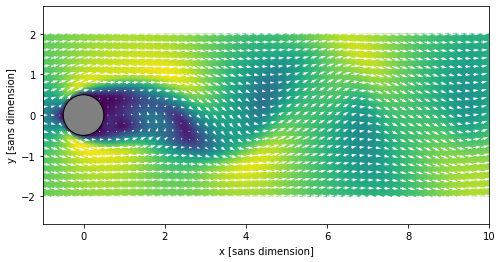

In [77]:
nx, ny = 111, 41
plot_field(mesh, X[:, 0], ny, nx, stride=2)

---

## L'analyse en composantes principales (PCA)

Contrairement à l'impression que la litérature dédiée au Machine Learning peut laisser entendre, l'analyse en composantes principales (ci-après abbréviée en **PCA**) n'est pas un outil propre à l'apprentissage machine.
Il s'agit avant tout d'une méthode d'analyse statistique redécouverte à plusieurs reprises au cours de l'histoire et dans différents domaines.
Ainsi, elle se nomme *Proper Orthogonal Decomposition* en ingénierie mécanique, *Empirical Orthogonal Functions* dans le domaine des sciences du climat ou encore *Kosambi-Karhunen-Loève transform* en traitement du signal.
D'un point de vue mathématique, elle est intimement liée à la [décomposition aux valeurs singulières](https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res).

### Le cadre théorique

Il existe plusieurs façons de définir la PCA, toutes équivalentes.
Dans la suite, nous adopterons un point de vue tiré de l'algèbre linéaire.
Cela permettra de clarifier certaines notions, notamment lors de l'implémentation de ces algorithmes.

Considérons une matrice $\mathbf{X} \in \mathbb{R}^{n \times k}$.
Chaque colonne de cette matrice est une réalisation différente de la même variable aléatoire.
On supposera par ailleurs que cette variable aléatoire est à moyenne nulle.
En pratique, cela revient à imposer que la moyenne des colonnes est égale à zéro (i.e. $\mathbf{x}_1 + \mathbf{x}_2 + \cdots + \mathbf{x}_k = 0$).
Une façon de formuler la PCA est via le problème de régression multivariée à contrainte de rang suivant

$$
\begin{aligned}
\text{minimiser } & \| \mathbf{X} - \mathbf{UU}^T \mathbf{X} \|_F^2 \\
\text{sujet à } & \mathbf{U}^T \mathbf{U} = \mathbf{I}_r
\end{aligned}
$$

où $r$ est le rang de $\mathbf{U}$ (i.e. le nombre de colonnes linéairement indépendantes).
On supposera que $r \ll n$.
Mathématiquement, cela revient à chercher la matrice $\hat{\mathbf{X}} = \mathbf{UU}^T \mathbf{X}$ de rang $r$ qui approxime au mieux notre matrice de données initiale.
La notation $\| \cdot \|_F$ dénote la [norme de Frobenius](https://fr.wikipedia.org/wiki/Norme_matricielle), une généralisation au cas des matrices de la norme Euclidienne à laquelle vous êtes habitués.

Si vous avez suivi un cours d'algèbre linéaire et/ou d'optimisation, alors il est facile de montrer que le problème d'optimisation ci-dessus est équivalent au suivant

$$
\begin{aligned}
\text{maximiser } & \text{Tr}\left( \mathbf{U}^T \mathbf{XX}^T \mathbf{U} \right) \\
\text{sujet à } & \mathbf{U}^T \mathbf{U} = \mathbf{I}_r.
\end{aligned}
$$

Ici, $\text{Tr}$ correspond à la trace de la matrice (i.e. $\text{Tr}(\mathbf{A}) = \sum_i A_{ii}$).
La matrice $\mathbf{XX}^T$ est symétrique définie positive.
La matrice $\mathbf{U}$ solution de ce problème est alors formée par les $r$ vecteurs $\mathbf{u}_i \in \mathbb{R}^n$ solutions du problème aux valeurs propres suivant

$$
\mathbf{XX}^T \mathbf{u}_i = \lambda_i \mathbf{u}_i
$$

et associés aux $r$ valeurs propres $\lambda_i$ les plus grandes.
D'un point de vue statistique, la matrice $\mathbf{XX}^T$ est (à un facteur près) la matrice de corrélation de la valeur étudiée.

#### Lien avec la décomposition aux valeurs singulières

La résolution du problème aux valeurs propres ci-dessus fait intervenir la matrice $\mathbf{XX}^T$ de taille $n \times n$.
Si $n$ est très large et que l'on a que $k \ll n$ observations, alors constuire explicitement cette matrice nécessite une quantité de mémoire excédent potentiellement nos capacités.
Dans ce cas, il est intéressant de noter que le même problème peut être résolu à l'aide de la [décomposition en valeurs singulières](https://fr.wikipedia.org/wiki/D%C3%A9composition_en_valeurs_singuli%C3%A8res).
Cette factorisation matricielle est une généralisation de la décomposition aux valeurs propres mais pour des matrices non-carrées.
Pour une matrice $\mathbf{X} \in \mathbb{R}^{n \times k}$ avec $n > k$, elle s'écrit (dans sa forme *économique*) de la façon suivante

$$
\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T.
$$

La matrice $\mathbf{U}$, de taille $n \times k$ et unitaire, est précisément celle que l'on cherche (ces $r$ premières colonnes en l'occurence).
La matrice $\boldsymbol{\Sigma}$ est une matrice diagonale où chacune de ses entrées (les valeurs singulières) est non-négative (i.e. $\sigma_i \geq 0$).
Enfin, la matrice $\mathbf{V} \in \mathbb{R}^{k \times k}$ est une matrice unitaire, $\mathbf{V}^T \mathbf{V} = \mathbf{I}_k$.

Dans le cas où $k \ll n$, il peut être avantageux de formuler le problème encore différement.
Si l'on considère la matrice $\mathbf{X}^T \mathbf{X}$, de taille $k \times k$, il est facile de montrer que ses valeurs propres (non nulles) sont identiques à celles de $\mathbf{XX}^T$ et égales à $\sigma_i^2$.
De la même façon, ses vecteurs propres sont précisément les colonnes de la matrice $\mathbf{V}$ définie précédemment.
Ainsi, après avoir résolu un problème aux valeurs propres de petite taille, la matrice $\mathbf{U}$ contenant les différentes composantes principales peut être obtenue à l'aide de l'expression suivante

$$
\mathbf{U} = \mathbf{X} \mathbf{V} \boldsymbol{\Sigma}^{-1}.
$$

Dans l'expression ci-dessus, on a tiré parti du fait que $\mathbf{V}^T \mathbf{V} = \mathbf{I}$.

### La PCA en mécanique des fluides

Dans le domaine de la mécanique des fluides et de l'ingénierie mécanique en générale, la PCA est plus connue sous le nom de *Proper Orthogonal Decomposition*.
A partir d'un ensemble d'instantanés du champ de vitesse (et/ou de pression) de l'écoulement, elle permet de décomposer ce champ en utilisant l'expansion de Galerkin suivante

$$
\mathbf{u}(\mathbf{x}, t) = \sum_{i=1}^r \mathbf{u}_i(\mathbf{x}) a_i(t).
$$

Elle peut alors être interprétée comme une généralisation des techniques de séparation de variables que vous avez pu voir dans vos cours de mathématiques pour résoudre des équations aux dérivées partielles.
A la différence de ces méthodes théoriques, la séparation de variables est ici basée directement sur les données que l'on a et non sur la structure de l'équation sous-jacente (que nous ne connaissons pas forcément).

![](imgs/svd_pod.png)

La POD est sans doute la méthode la plus utilisée en mécanique des fluides pour essayer d'extraire des *structures cohérentes* dans l'écoulement (e.g. des structures tourbillonaires particulières).
Dans le domaine de la modélisation réduite, cette base de représentation de la solution peut ensuite être utilisée pour projeter les équations de la dynamique dessus et ainsi obtenir un jeu réduit d'équations.
Parce que de plus faible dimension ($r$ au lieu de $n$), ce modèle réduit peut ensuite être utilisé pour tenter de simuler ou contrôler le système en temps réel.
Pour en savoir plus concernant le domaine du modèle réduit, je vous conseille le livre suivant [Data-driven Science and Engineering](http://www.databookuw.com/) par Steven Brunton et Nathan Kutz et disponible gratuitement sur leur site web.

### Implémentation

De nombreuses bibliothèques déjà existantes en `python` proposent des implémentations clef en main de la PCA.
La plus populaire est sans aucun doute [scikit-learn](https://scikit-learn.org/stable/) (bien qu'elle utilise la convection de vecteurs lignes plutôt que de vecteurs colonnes comme ici).
Implémenter soit-même la PCA est cependant une tâche extrêment facile à l'aide de `numpy` et `scipy`.

In [59]:
from scipy.linalg import svd

def pca_svd(X, rank=10):
    # --> Décomposition aux valeurs singulières.
    U, Σ, Vt = svd(X, full_matrices=False)
    return U[:, :rank], Σ**2, Vt[:rank]

In [60]:
from scipy.linalg import eigh, pinv

def pca_eig(X, rank=10):
    # --> Taille de la matrice.
    n, k = X.shape
    
    # --> Case 1 : Skinny matrix.
    if n > k:
        # --> Matrice de covariance.
        C = X.T @ X
        
        # --> Décomposition aux valeurs propres.
        Λ, V = eigh(C)
        V = V[:, :rank]
        
        # --> Calcul des composantes principales.
        U = X @ V @ pinv(np.diag(np.sqrt(Λ[:rank])))
        
    # --> Case 2 : Fat matrix.
    else:
        # --> Matrice de covariance.
        C = X @ X.T
        
        # --> Décomposition aux valeurs propres.
        Λ, U = eigh(C)
        U = U[:, :rank]
        
    return U, Λ, U.T @ X

In [61]:
def pca(X, rank=10, method="svd"):
    if method.lower() == "svd":
        return pca_svd(X, rank=rank)
    if method.lower() == "eig":
        return pca_eig(X, rank=rank)
    else:
        raise ValueError("Chosen method not implemented!")

### Application au cas de l'écoulement derrière un cylindre (données numériques)

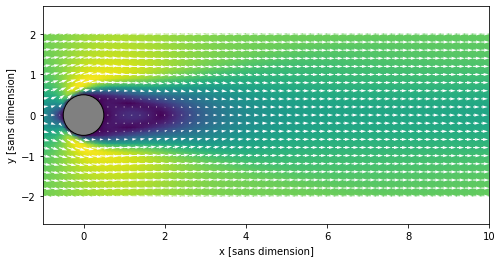

In [78]:
# --> Calcul du champ moyen.
X̄ = np.mean(X, axis=1)

# --> Trace le champ moyen.
plot_field(mesh, X̄, ny, nx, stride=2)

In [63]:
# --> Extrait les fluctuations.
X_fluctuation = X - X̄.reshape(-1, 1)

# --> Calcul de la POD.
U, Λ, z = pca(X_fluctuation)

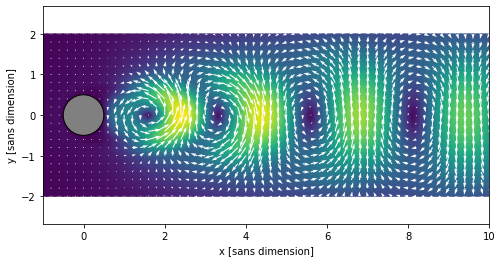

In [79]:
plot_field(mesh, U[:, 0], ny, nx, stride=2)

[Text(0.5, 0, 'Rang du modèle'), Text(0, 0.5, 'Valeurs propres PCA')]

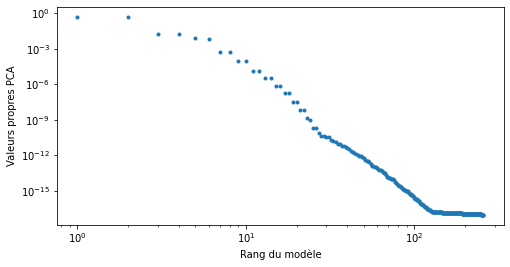

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.loglog(range(1, len(Λ)//2+1), Λ[:len(Λ)//2] / np.sum(Λ), ".")

ax.set(xlabel="Rang du modèle", ylabel="Valeurs propres PCA")

[Text(0.5, 0, 'Time')]

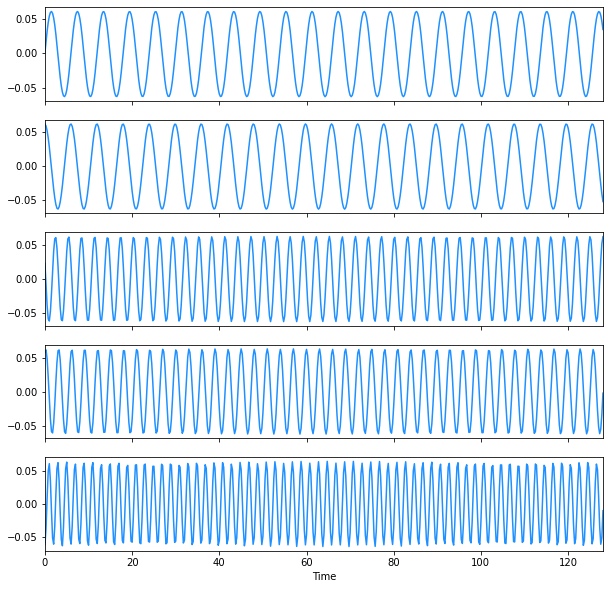

In [73]:
Δt = 25*0.01
t = np.arange(0, X.shape[1]) * Δt

fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t, z[i], color="dodgerblue")
    ax.set(xlim=(0, 128))
    
axes[-1].set(xlabel="Time")

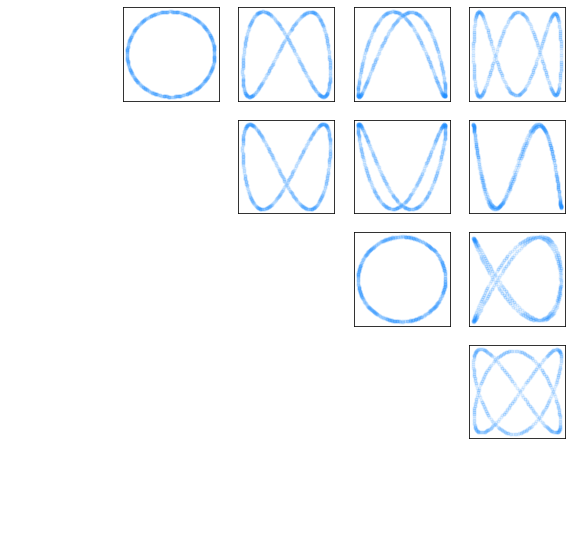

In [74]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        
        if i >= j:
            axes[i, j].axis("off")
        else:
            axes[i, j].plot(z[i], z[j], ".", alpha=0.1, color="dodgerblue")
            axes[i, j].set(xticks=[], yticks=[])
            

### Application au cas de l'écoulement derrière un cylindre (données expérimentales)

Une base de données expérimentales a été gracieusement mise à disposition par [Miguel Alfonso Mendez](https://mendezvki.github.io/), enseignant-chercheur à l'[Institut von Kàrmàn](https://www.vki.ac.be/) en Belgique.
Pour en savoir plus concernant cette base de données, vous pouvez référer à ses notes de cours [Statistical Treatment, Fourier and Modal Decomposition](https://arxiv.org/abs/2201.03847) ainsi qu'à son article [Multiscale proper orthogonal decomposition (mPOD) of TR-PIV data - a case study on stationary and transient cylinder wake flows](https://iopscience.iop.org/article/10.1088/1361-6501/ab82be).

In [89]:
# --> Load the dataset.
dataset = np.load("vki_cylinder_dataset.npz")

# --> Extract the mesh and the snapshots.
mesh, X = dataset["mesh"], dataset["data"]

# --> Normalize mesh dimension w.r.t. the cylinder's diameter.
mesh /= 5

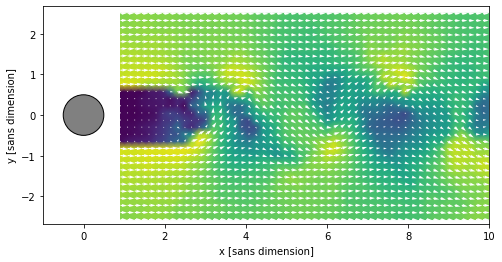

In [90]:
nx, ny = 30, 71
plot_field(mesh, X[:, 0], nx, ny)

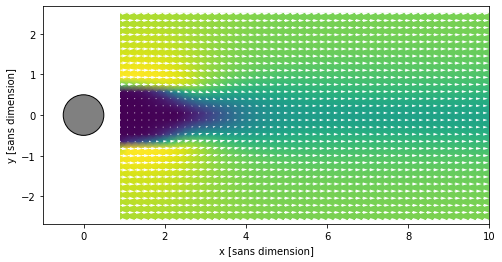

In [91]:
# --> Calcul du champ moyen.
X̄ = np.mean(X, axis=1)

# --> Trace le champ moyen.
plot_field(mesh, X̄, nx, ny)

In [92]:
# --> Extrait les fluctuations.
X_fluctuation = X - X̄.reshape(-1, 1)

# --> Calcul de la POD.
U, Λ, z = pca(X_fluctuation)

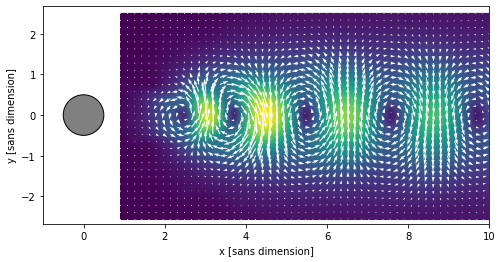

In [93]:
plot_field(mesh, U[:, 0], nx, ny)

[Text(0.5, 0, 'Rang du modèle'), Text(0, 0.5, 'Valeurs propres PCA')]

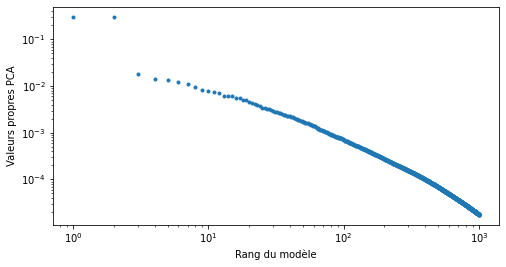

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.loglog(range(1, 1001), Λ[:1000] / np.sum(Λ), ".")

ax.set(xlabel="Rang du modèle", ylabel="Valeurs propres PCA")

[Text(0.5, 0, 'Time')]

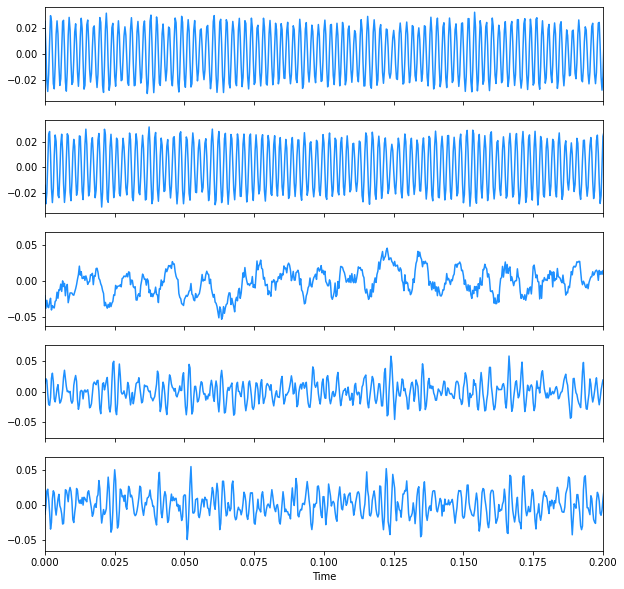

In [95]:
Δt = 1 / 3000
t = np.arange(0, 3000) * Δt

fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(t, z[i], color="dodgerblue")
    ax.set(xlim=(0, 0.2))
    
axes[-1].set(xlabel="Time")

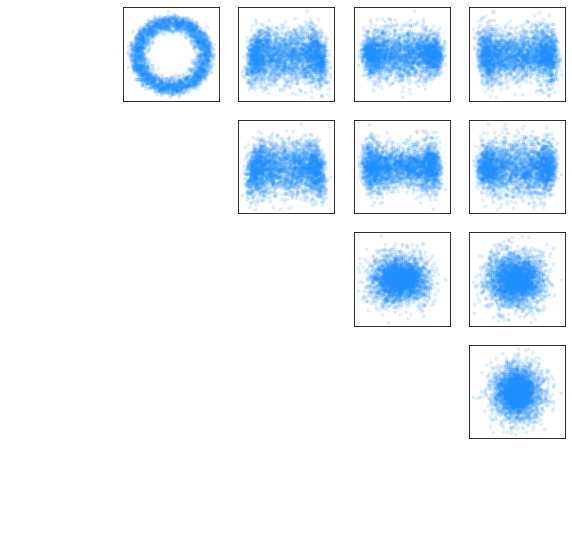

In [96]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        
        if i >= j:
            axes[i, j].axis("off")
        else:
            axes[i, j].plot(z[i], z[j], ".", alpha=0.1, color="dodgerblue")
            axes[i, j].set(xticks=[], yticks=[])
            